In [1]:
#We get all dependencis we need for a Keras NN
#If you need a module do: "!pip install [module_name]""
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import secrets
import itertools
import pickle
import matplotlib.pylab as plt

from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# Get our `labelled` table as df - This is going to be our training set
# Note that we are removing a URL because we will use that URL for testing
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df_0s = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight=0 AND url<>"https://www.youtube.com/watch?v=0AlFcix7aaY" LIMIT 2493', con=db_conn)
df_1s = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight=1 AND url<>"https://www.youtube.com/watch?v=0AlFcix7aaY"', con=db_conn)
df_test = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight IS NOT NULL AND url="https://www.youtube.com/watch?v=0AlFcix7aaY"', con=db_conn)
db_conn.dispose()

df = df_0s.append(df_1s)
df.head()

,pitch,amplitude,subjectivity,polarity,pred_excitement,isHighlight
0,49.9597,0.000801,0.000000,0.000000,0,0
1,58.7970,0.000655,0.000000,0.000000,1,0
2,61.5320,-0.000205,0.000000,0.000000,1,0
3,59.4878,0.000786,0.026786,-0.008929,1,0
4,59.9587,-0.000265,0.000000,0.000000,1,0


In [3]:
# Extract the labels
labels = np.array(df.pop('isHighlight'))
# Set random seed to ensure reproducible runs
RSEED = 1

X, X_test, y, y_test = train_test_split(df, labels, test_size = 0.3, random_state = RSEED, shuffle=True)

In [4]:
#Only take relevant columns for input and classification
X.head()
print('Number of Rows (Train):', len(X.index))
print('Number of Rows (Test):', len(X_test.index))

Number of Rows (Train): 3490
Number of Rows (Test): 1496


In [5]:
# Define the keras model
# Currently - Input Layer = 5 nodes ; Hidden Layer 1 = 10 nodes ; Hidden Layer 2 = 8 ; Output Layer = 1 node
model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# Compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# Fit the keras model on the dataset
model.fit(X, y, validation_data=(X_test,y_test), epochs=100, batch_size=20)


Train on 3490 samples, validate on 1496 samples
Epoch 1/100
3490/3490 [==============================] - 1s 372us/step - loss: 0.7156 - accuracy: 0.5771 - val_loss: 0.6608 - val_accuracy: 0.4880
Epoch 2/100
3490/3490 [==============================] - 1s 143us/step - loss: 0.6420 - accuracy: 0.6573 - val_loss: 0.6316 - val_accuracy: 0.7366
Epoch 3/100
3490/3490 [==============================] - 0s 133us/step - loss: 0.6132 - accuracy: 0.7221 - val_loss: 0.6043 - val_accuracy: 0.7373
Epoch 4/100
3490/3490 [==============================] - 0s 123us/step - loss: 0.5817 - accuracy: 0.7473 - val_loss: 0.5829 - val_accuracy: 0.6925
Epoch 5/100
3490/3490 [==============================] - 0s 114us/step - loss: 0.5564 - accuracy: 0.7473 - val_loss: 0.5567 - val_accuracy: 0.7373
Epoch 6/100
3490/3490 [==============================] - 0s 110us/step - loss: 0.5395 - accuracy: 0.7418 - val_loss: 0.5445 - val_accuracy: 0.7373
Epoch 7/100
3490/3490 [==============================] - 0s 108us/ste

3490/3490 [==============================] - 0s 128us/step - loss: 0.4826 - accuracy: 0.7630 - val_loss: 0.4887 - val_accuracy: 0.7493
Epoch 55/100
3490/3490 [==============================] - 0s 123us/step - loss: 0.4807 - accuracy: 0.7676 - val_loss: 0.4880 - val_accuracy: 0.7480
Epoch 56/100
3490/3490 [==============================] - 0s 117us/step - loss: 0.4810 - accuracy: 0.7636 - val_loss: 0.4890 - val_accuracy: 0.7460
Epoch 57/100
3490/3490 [==============================] - 0s 132us/step - loss: 0.4794 - accuracy: 0.7639 - val_loss: 0.4878 - val_accuracy: 0.7467
Epoch 58/100
3490/3490 [==============================] - 0s 129us/step - loss: 0.4855 - accuracy: 0.7673 - val_loss: 0.4948 - val_accuracy: 0.7513
Epoch 59/100
3490/3490 [==============================] - 0s 128us/step - loss: 0.4819 - accuracy: 0.7622 - val_loss: 0.4907 - val_accuracy: 0.7513
Epoch 60/100
3490/3490 [==============================] - 0s 130us/step - loss: 0.4815 - accuracy: 0.7625 - val_loss: 0.4912 

In [8]:
# Evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

3490/3490 [==============================] - 0s 23us/step
Accuracy: 76.53


In [9]:
# Make class predictions for a test
predictions_p = model.predict(X_test)

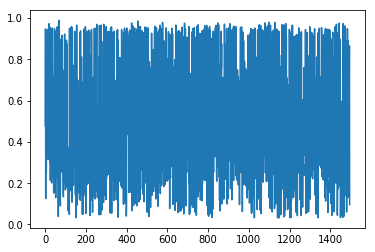

In [10]:
#Print out probabilities of an interval being a highlight
plt.plot(predictions_p)
plt.show()

In [11]:
# So here we have 2 options.
# OPTION 1 
# We could assign a threshold - any point that has a greater probability of being a highlight than the threshold will be classified as a highlight

predictions = []
threshold = 0.4
for i in range(len(predictions_p)):
    if predictions_p[i] >= threshold:
        predictions.append(1)
    else:
        predictions.append(0)



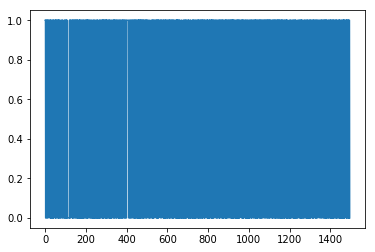

In [12]:
# Print out predictions
plt.plot(predictions)
plt.show()

In [13]:
# This function outputs a confusion matrix for us
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[510 258]
 [107 621]]


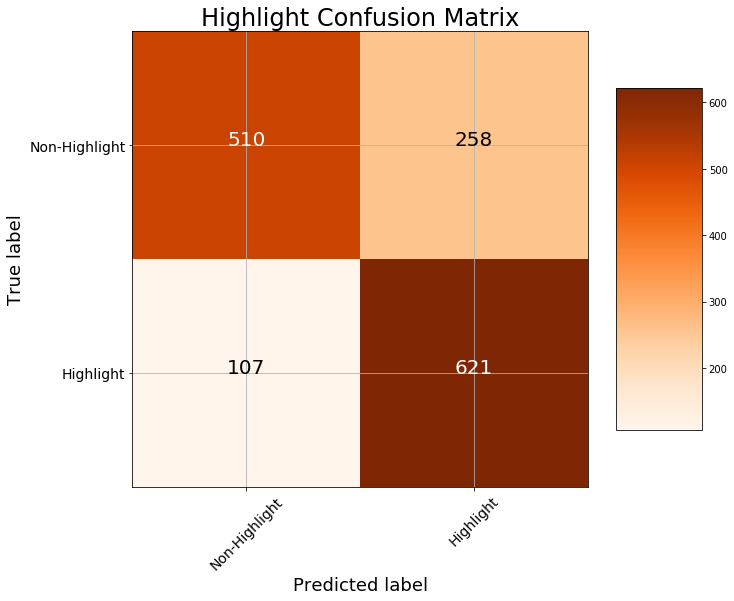

In [14]:
# OPTION 1 gives us the following results:
# Output Confusion Matrix given function above
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

In [15]:
# Save the model to disk
filename = 'nn_2layers_0.4.sav'
pickle.dump(model, open(filename, 'wb'))

In [16]:
# OPTION 2
# Just use a function that automatically predicts classes - this is the same as having a threshold of 0.5
predictions = model.predict_classes(X_test)

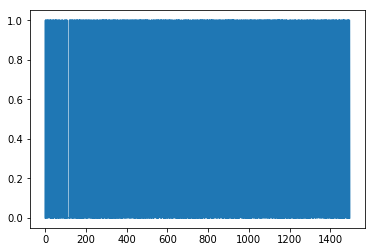

In [17]:
# Print out predictions
plt.plot(predictions)
plt.show()

Confusion matrix, without normalization
[[549 219]
 [153 575]]


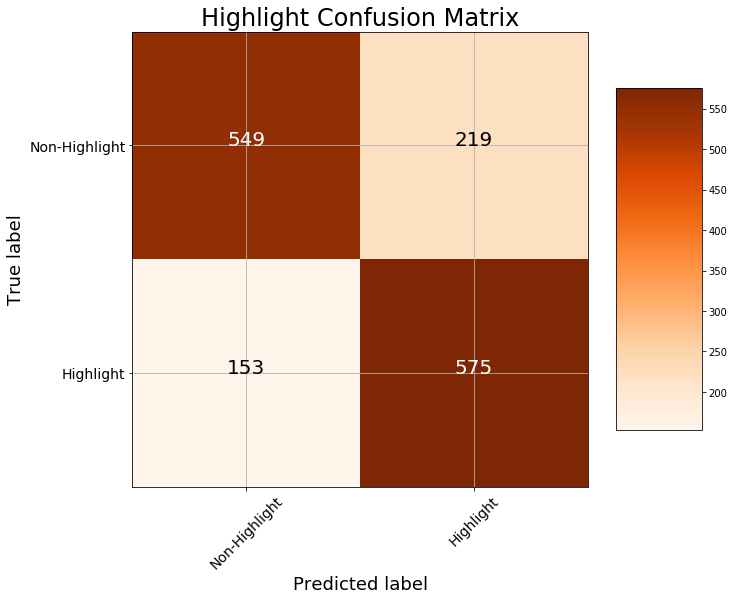

In [18]:
# OPTION 2 gives us the following results:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

In [19]:
# Save the model to disk
filename = 'nn_2layers_0.5.sav'
pickle.dump(model, open(filename, 'wb'))